In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

#device = torch.device("cpu")

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


In [3]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
        use_final_relu = True,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        
        # BK: Force last layers back to inplanes
        self.conv3 = conv1x1(width, inplanes)
        self.bn3 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        self.use_final_relu = use_final_relu

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        #out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        if self.use_final_relu:
            out = self.relu(out)

        return out

In [4]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = tuple([-1] + list(shape))
        
    def forward(self, x):
        return torch.reshape(x, self.shape)

def dense_backbone(shape, network_width):
    input_width = shape[0] * shape[1] * shape[2]
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, input_width),
        Reshape(shape)
    )

def bottleneck_backbone(planes):
    return nn.Sequential(
        Bottleneck(1, planes),
        Bottleneck(1, planes),
        Bottleneck(1, planes),
        Bottleneck(1, planes, use_final_relu=False),
    )

mask = {}
mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global mask, mask_device
    if shape not in mask:
        mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        mask[shape] = torch.Tensor(mask[shape])
        
    if to_device and shape not in mask_device:
        mask_device[shape] = mask[shape].to(device)
        
    return mask_device[shape] if to_device else mask[shape]

In [5]:
class NormalizingFlowMNist(nn.Module):
    EPSILON = 1e-7
    
    def __init__(self, num_coupling, planes):
        super(NormalizingFlowMNist, self).__init__()
        self.num_coupling = num_coupling
        self.shape = (1, 28, 28)
        
        self.planes = planes
        self.s = nn.ModuleList([bottleneck_backbone(planes) 
                                for x in range(num_coupling)])
        self.t = nn.ModuleList([bottleneck_backbone(planes)
                                for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = nn.ParameterList([torch.nn.Parameter(torch.randn(self.shape)) 
                                         for x in range(num_coupling)])
        for i in range(num_coupling):
            self.s_scale[i].requires_grad = True
            
        self.validation = False
    
    def validate(self):
        self.validation = True
        self.eval()
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        if mode:
            self.validation = False

    def forward(self, x):
        if model.training or self.validation:
            s_vals = []
            for i in range(self.num_coupling):
                mask = checkerboard_mask(self.shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = self.t[i](mask * x)
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append((1 - mask) * s)
                
                x = y

            # Return outputs and vars needed for determinant
            return y, torch.cat(s_vals), torch.cat(list(self.s_scale))
        else:
            y = x
            for i in reversed(range(self.num_coupling)):
                mask = checkerboard_mask(self.shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = self.t[i](mask * y)
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
                
                y = x
                
            return x

In [6]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ...
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    reg = 5e-5 * torch.sum(scale ** 2)
    ret = -(logpx + det) + reg
    return torch.div(ret, batch_size)

# MNist Training

In [7]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)
    
    # Apply transform to deal with boundary effects (see realNVP paper)
    x = torch.logit(0.05 + 0.90 * x / 256)
    
    return x

def post_process(x):
    # Convert back to integer values
    return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255

In [8]:
train_dataset = datasets.MNIST('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                               ]))
test_dataset = datasets.MNIST('data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                              ]))

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10, num_pixels=28*28):
    size = len(dataloader)
    prev = []
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, scale = model(X)
        loss = loss_fn(y, s, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        prev = [(name, x, x.grad) for name, x in model.named_parameters(recurse=True)]
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:.2f}; {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, num_pixels=28*28):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, scale = model(X)
            test_loss += loss_fn(y, s, scale, batch_size)
        model.train()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")

In [ ]:
learning_rate = 0.001
batch_size = 100
epochs = 5

model = NormalizingFlowMNist(6, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) #shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 3871.44; 7.12  [    0/  600]
loss: 1122.14; 2.06  [   10/  600]
loss: 929.14; 1.71  [   20/  600]
loss: 924.58; 1.70  [   30/  600]


In [ ]:
# DEBUG

model.train()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, scale = model(x_pre)
        break

model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
torch.any(torch.abs(diff) > 1e-7)

In [ ]:
print(diff.shape)

for i in range(100):
    if torch.any(torch.abs(diff[i]) > 1e-3):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1e-3):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
        break

In [ ]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 1, 28, 28))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

In [ ]:
Y

In [ ]:
#train_dataset[0][0]
samples[0, 0]

In [ ]:
model.eval()

cols, rows = 3, 3
with torch.no_grad():
    X = torch.Tensor(torch.randn((cols * rows, 1, 28, 28))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

figure = plt.figure(figsize=(8, 8))
for i in range(1, cols * rows + 1):
    img = samples[i - 1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
samples[0, 0, :, :] * 255

In [ ]:
x = 100 / 255
post_process(pre_process(torch.tensor(x))), x

# 2022-02-05

* Looks like the inverse operation is working as expected:
  * Pass in a vector in forward pass pixels -> pre_process -> gaussian -> post_process -> pixels and get the same number (with some small 10e-8 errors, also had some 10-3 errors but much more seldom)
* Added L2 regularizer on s_scale param, not much changed
* I keep getting a shifted distribution (negative mean) and less than 1 std when I take a batch of training and pass it through a forward pass to get z
  * Tried removing the det terms and it still looks skewed
* INVESTIGATE: This seems like it's relevant because if I'm sampling from a 0-mean Gaussian but real examples always end up shifted left, then of course I'm going to generate bad images

# 2022-02-02

* Implemented post-processing to convert back to pixel space but still seems like I'm getting garbage, need to debug further.
* Ideas to double check:
    * loss function
    * inverse operation (should check back and forwards give the same answer)
    * Check that forward pass actually gives something Gaussian like...

# 2022-02-01

* Finally got around to actually generating images... and they are just noise!
* Might be a bug in the network, might be that I need to increase capacity of network.  Now the fun starts!
    * I might also have to add the "multi-scale architecture"
    * Another issue might be the batch-norm layers, which probably behave very differently in testing -- I actually did comment it out.
    
    
I NEED TO CONVERT BACK TO PIXEL SPACE!!!!

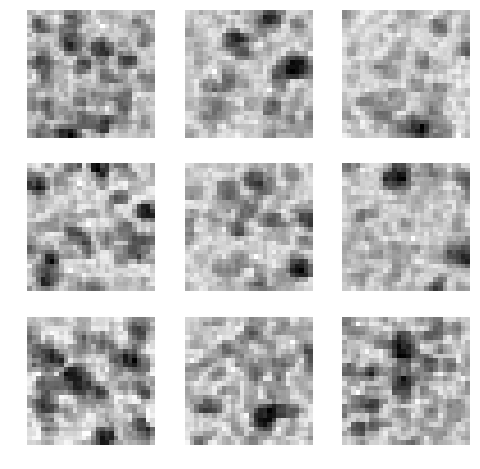

# 2022-01-31

* The negative values are coming from determinant because log |df/dx| = log(|exp(s)|) = s
* So the loss is essentially trying to make `s` very large (more negative).
* Theoretically, it's possible by allowing the unmasked variables to almost exactly predict the masked variables, so you could multiply by a large number s(unmasked) vars, and adjust by t(unmasked) = -s(unmasked) * unmasked, to get the maximum s*masked_x - t = s*unmasked_x - s*unmasked_x = 0, which is the maximum density point for the Gaussian
* Need to look into how the determinant (i.e. s) is be generated.  From prelim debugging above, it looks like it's generating a lot of zeros (even in unmasked positions), so I have to sort out why that's the case.

Wait... found a bug.  I was putting the determinant as `mask * s` instead of the correct `(1 - mask) * s`.


# 2022-01-29

* Getting lots of NaNs -- debugged a bunch of things:
    * Removed Resnet
    * Removed exp()
    * Made forward pass a simple feedforward
* But it looks like issue is the data???    
    * The stupid paper said the transform should be `logit(alpha + (1-alpha)*x/256)`...
    * Data is originally in [0,1] (pytorch dataset)
    * Convert back to pixels multiply by 255
    * Add jitter to get upper bound on bits per pixel (see my post)
    * Range is now [0, 256]
    * Suggested alpha=0.05 (I had a bug and used 0.5)
    * But that gets you really close to 256 (jitter is always less than 1.0 though) e.g.i logit(0.05 + 0.95 * ~255.99/256) ~= \inf!
    * Instead, I used this `logit(alpha + (1-alpha - 0.05)*x/256)`, which is symmetrical...
    
NEXT STEPS:
* So things look good now, except that I get a negative loss, which shouldn't happen (after applying jitter)???
    * It's because I need a new uniform noise sample per EPOCH???
    * Or is it because I'm using continuous variables on the output?  So maybe I just need to measure this "loss" when I reverse the network?  
        * It's probably this... if it's a continuous output, the log density surely doesn't need to be positive (vs. if I were directly outputting pixel values).
        
        
I THINK I FIGURED IT OUT:  IT's becuase I didn't have the 1/sqrt(2pi) in the log-likelihood!